In [8]:
import os
import pandas as pd
import sys
import numpy as np
import sys
sys.path.insert(0, '../..')
import itertools

from genepy.utils import helper as h
from genepy.epigenetics import chipseq as chip

import dalmatian as dm
import pyBigWig

from bokeh.plotting import *
from IPython.display import IFrame
import igv
from biomart import BiomartServer
import io

from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

In [ ]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
gsheet = sheets.get(url).sheets[2].to_frame()

In [ ]:
gsheet

## v10

In [2]:
project="knockouts_v1"
loc1= "201222_MP8548_fastq"
loc2= "201204_MP8489_fastq"

In [ ]:
fastq2 = ! gsutil ls gs://transfer-amlproject/$loc2/
fastq2

In [ ]:
fastq1 = ! gsutil ls gs://transfer-amlproject/$loc1/
fastq1

In [ ]:
mkdir ../data/$project/ && mkdir ../data/$project/qc/

In [ ]:
!gsutil -m cp gs://transfer-amlproject/$loc1/multiqc_report.html ../data/$project/qc/
!gsutil -m cp -r gs://transfer-amlproject/$loc1/Reports/ ../data/$project/qc/
!gsutil -m cp -r gs://transfer-amlproject/$loc1/multiqc_data/ ../data/$project/qc/
    
!gsutil -m cp gs://transfer-amlproject/$loc2/multiqc_report.html ../data/$project/qc2/
!gsutil -m cp -r gs://transfer-amlproject/$loc2/Reports/ ../data/$project/qc2/
!gsutil -m cp -r gs://transfer-amlproject/$loc2/multiqc_data/ ../data/$project/qc2/

In [ ]:
! gsutil -m cp gs://transfer-amlproject/$loc1/*  gs://transfer-amlproject/$project/
! gsutil -m cp gs://transfer-amlproject/$loc2/*  gs://transfer-amlproject/$project/

### analysis

In [ ]:
rename = {
"20201222_FLAG_DMSO_2h_MP8548_S1": "mp931-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r5",
"20201222_FLAG_VHL_2h_MP8548_S6": "mp932-MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D-r5",
"20201222_MED1_DMSO_2h_MP8548_S3": "mp933-MV411_MEF2D_NT_SC_63_DMSO-MED1-r3",
"20201222_MED1_VHL_2h_MP8548_S8": "mp934-MV411_MEF2D_NT_SC_63_VHL_2h-MED1-r3",
"20201222_MEF2C_DMSO_2h_MP8548_S5": "mp935-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r3",
"20201222_MEF2C_VHL_2h_MP8548_S10": "mp936-MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C-r3",
"20201222_MYC_DMSO_2h_MP8548_S2": "mp937-MV411_MEF2D_NT_SC_63_DMSO-MYC-r3",
"20201222_MYC_VHL_2h_MP8548_S7": "mp938-MV411_MEF2D_NT_SC_63_VHL_2h-MYC-r3",
"20201222_POL_II_DMSO_2h_MP8548_S4": "mp939-MV411_MEF2D_NT_SC_63_DMSO-POLII_total-r3",
"20201222_POL_II_VHL_2h_MP8548_S9": "mp940-MV411_MEF2D_NT_SC_63_VHL_2h-POLII_total-r3",
"20201204_DMSO_FLAG_MEF2D_degron_2h_MP8489_S47": "mp941-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r6",
"20201204_DMSO_MED1_MEF2D_degron_2h_MP8489_S49": "mp942-MV411_MEF2D_NT_SC_63_DMSO-MED1-r4",
"20201204_DMSO_MEF2C_MEF2D_degron_2h_MP8489_S51": "mp943-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r4",
"20201204_DMSO_MYC_MEF2D_degron_2h_MP8489_S48": "mp944-MV411_MEF2D_NT_SC_63_DMSO-MYC-r4",
"20201204_DMSO_POL_II_MEF2D_degron_2h_MP8489_S50": "mp945-MV411_MEF2D_NT_SC_63_DMSO-POLII_total-r4",
"20201204_VHL_FLAG_MEF2D_degron_2h_MP8489_S52": "mp946-MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D-r6",
"20201204_VHL_MED1_MEF2D_degron_2h_1_MP8489_S54": "mp947-MV411_MEF2D_NT_SC_63_VHL_2h-MED1-r4",
"20201204_VHL_MED1_MEF2D_degron_2h_2_MP8489_S56": "mp948-MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C-r4",
"20201204_VHL_MYC_MEF2D_degron_2h_MP8489_S53": "mp949-MV411_MEF2D_NT_SC_63_VHL_2h-MYC-r4",
"20201204_VHL_POL_II_MEF2D_degron_2h_MP8489_S55": "mp950-MV411_MEF2D_NT_SC_63_VHL_2h-POLII_total-r4",}

In [ ]:
for val in fastq1+fastq2:
    rep = val
    for k,v in rename.items():
        rep = rep.replace(k,v)
    rep = rep.replace('transfer-amlproject/'+loc1+'/',"amlproject/Chip/"+project+'/fastqs/').replace('transfer-amlproject/' + loc2 + '/', "amlproject/Chip/"+project+'/fastqs/')
    !gsutil cp $val $rep

In [ ]:
! gsutil rm gs://amlproject/Chip/chipseq_MEF2C_2h_degraded/fastqs/multiqc_report.html

In [ ]:
fastq = ! gsutil ls gs://amlproject/Chip/$project/fastqs/
fastq

In [ ]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in h.grouped(fastq,2):
    row = gsheet[gsheet.id==val[0].split('/')[-1].split('-')[0]]
    df['group'].append("MV4"+row['name'].values[0].split('-r')[0].split('-MV4')[1])
    df['replicate'].append(df['group'].count(df['group'][-1]))
    df['fastq_1'].append(val[0])
    df['fastq_2'].append(val[1])
    df['antibody'].append(row['protein'].values[0])
    df['control'].append("INPUT")
df['group'].append('INPUT')
df['replicate'].append(1)
df['fastq_1'].append('gs://amlproject/Chip/IRF2BP2_degraded_rep3/fastqs/mp845-MV411-INPUT-r2_R1.fastq.gz')
df['fastq_2'].append('gs://amlproject/Chip/IRF2BP2_degraded_rep3/fastqs/mp845-MV411-INPUT-r2_R2.fastq.gz')
df['antibody'].append("")
df['control'].append("")
df = pd.DataFrame(df)
df

In [ ]:
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_design.csv',index=False)

In [ ]:
project

### about

0. you need to have a google project set up with a billing account
1. you need to activte your APIs this way: https://cloud.google.com/life-sciences/docs/tutorials/nextflow?hl=fr
2. nextflow needs to be installed with this installation command `export NXF_MODE=google && curl https://get.nextflow.io | bash`

In [ ]:
! cd ../../ && ./nextflow log ## to get access to the previous runs

In [ ]:
#process chips 
! cd ../../ && ./nextflow run jkobject/chipseq --paired_end --seq_center 'DFCI' --email 'jkobject@gmail.com' --input AMLproject/nextflow/chipseq_MEF2C_2h_degraded_design.csv --genome GRCh38 --max_cpus 16 --skip_diff_analysis -profile jkcloud -w gs://workamlproject/MEF2C2hres --spiking --outdir gs://workamlproject/MEF2C2h --tracedir AMLproject/nextflow/MEF2Cdegraded2h/

In [ ]:
! gsutil -m cp -r gs://workamlproject/MEF2C2h/* gs://amlproject/Chip/$project/

In [ ]:
! gsutil cat gs://amlproject/Chip/$project/droso_aligned/counts/*
! gsutil ls gs://amlproject/Chip/$project/droso_aligned/counts/

In [ ]:
project

In [ ]:
# now use the total counts in gs://amlproject/Chip/chipseq_MF2C_degraded_v2/multiqc/broadPeak/multiqc_report.html
# https://console.cloud.google.com/storage/browser/amlproject/Chip/chipseq_MF2C_degraded_v2/multiqc/broadPeak/multiqc_report.html

In [ ]:
h.createFoldersFor('../../data/'+project+'/bwa/mergedLibrary/')
!gsutil -m cp gs://amlproject/Chip/$project/bwa/mergedLibrary/*.ba* ../../data/$project/bwa/mergedLibrary/
! gsutil -m cp -r gs://amlproject/Chip/$project/bwa/mergedLibrary/bigwig/ ../../data/$project/bwa/mergedLibrary/
! gsutil  -m cp -r gs://amlproject/Chip/$project/bwa/mergedLibrary/macs/ ../../data/$project/bwa/mergedLibrary/

computing scales from the excel sheet

In [91]:
scales = [
1,
1,
0.3011826465, # 'MV411_RNP_IRF8-H3K27AC_R1',
0.4865371752, # 'MV411_RNP_IRF8-H3K27AC_R2',
0.5670857556, # 'MV411_RNP_MEF2D-H3K27AC_R1',
0.7349663619, # 'MV411_RNP_MEF2D-H3K27AC_R2',
0.7548163023, # 'MV411_RNP_MYB-H3K27AC_R1',
0.5976325206, # 'MV411_RNP_MYB-H3K27AC_R2',
1.400750948, # 'MV411_RNP_RUNX1-H3K27AC_R1',
0.849637265, # 'MV411_RNP_RUNX1-H3K27AC_R2',
0.7539535476, # 'MV411_RNP_RUNX1_RUNX2-H3K27AC_R1',
0.6905692051, # 'MV411_RNP_RUNX1_RUNX2-H3K27AC_R2',
1.50505384, # 'MV411_RNP_RUNX2-H3K27AC_R1',
0.8442345485, # 'MV411_RNP_RUNX2-H3K27AC_R2',
0.5019100631, # 'MV411_RNP_SPI1-H3K27AC_R1',
0.8688220473, # 'MV411_RNP_SPI1-H3K27AC_R2'
         ]

In [94]:
h.createFoldersFor("../../data/"+project+"/bwa/mergedLibrary/bigwig/scale/")

In [95]:
! gsutil -m cp gs://amlproject/Chip/$project/bwa/mergedLibrary/bigwig/scale/*.txt ../../data/$project/bwa/mergedLibrary/bigwig/scale/

Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/scale/INPUT_R1.mLb.clN.scale_factor.txt...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/scale/MV411_RNP_AAVS1-H3K27AC_R1.mLb.clN.scale_factor.txt...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/scale/MV411_RNP_AAVS1-H3K27AC_R2.mLb.clN.scale_factor.txt...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/scale/MV411_RNP_IRF8-H3K27AC_R1.mLb.clN.scale_factor.txt...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/scale/MV411_RNP_IRF8-H3K27AC_R2.mLb.clN.scale_factor.txt...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/scale/MV411_RNP_MEF2D-H3K27AC_R1.mLb.clN.scale_factor.txt...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/scale/MV411_RNP_MEF2D-H3K27AC_R2.mLb.clN.scale_factor.txt...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/scale/MV411_RNP_MYB-H3K27AC_R1.mLb.clN.scale_factor.txt..

In [96]:
bams = ! ls ../../data/$project/bwa/mergedLibrary/*.bam
bams

['../../data/knockouts_v1/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_AAVS1-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_AAVS1-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_IRF8-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_IRF8-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_MEF2D-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_MEF2D-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_MYB-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_MYB-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_RUNX1-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_RUNX1-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data

### on scalled data

In [ ]:
! mkdir ../../data/$project/diffPeaks/ && ! mkdir ../../data/$project/diffData/

In [ ]:
wigs = ! ls ../../data/$project/bwa/mergedLibrary/bigwig/*.bigWig
wigs

In [ ]:
# diffPeak on scaled data (full reprocessing)
for i in range(int(len(bams)/2)):
    if i < 0:
        continue
    bam1 = bams[1+i]
    bam2 = bams[11+i]
    print(bam1,bam2)
    print(chip.fullDiffPeak(bam1,bam2, control1=bams[0], scaling=[scales[i], scales[i+10]], directory = "../../data/"+project+"/diffData/", res_directory = "../../data/"+project+"/diffPeaks/",pairedend=True))

In [97]:
initscales = ! cat ../../data/$project/bwa/mergedLibrary/bigwig/scale/*.txt
initscales

['0.00744797',
 '0.0241142',
 '0.0180527',
 '0.0184016',
 '0.0196455',
 '0.017496',
 '0.016778',
 '0.0255477',
 '0.0154068',
 '0.0203982',
 '0.011366',
 '0.0264153',
 '0.0260119',
 '0.0229741',
 '0.0129456',
 '0.0180742',
 '0.0181613']

In [100]:
rescales = [val*float(initscales[1+2+i]) for i, val in enumerate(scales[2:])]
rescales

[0.0055422425878344,
 0.0095582660753916,
 0.0099217323799776,
 0.0123312656199582,
 0.01928382044626971,
 0.00920760471838008,
 0.028572797987493598,
 0.00965697715399,
 0.01991590914591828,
 0.01796301710614069,
 0.034577257425544,
 0.0109291227710616,
 0.00907162286248202,
 0.015778937847629487]

In [128]:
bams[3:]

['../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_IRF8-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_IRF8-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_MEF2D-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_MEF2D-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_MYB-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_MYB-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_RUNX1-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_RUNX1-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_RUNX1_RUNX2-H3K27AC_R1.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_RUNX1_RUNX2-H3K27AC_R2.mLb.clN.sorted.bam',
 '../../data/knockouts_v1/bwa/mergedLibrary/MV411_RNP_RUNX2-H3K27AC_R1.mLb

In [101]:
chip.bigWigFrom(bams[3:], 
                genome='GRCh38',scaling=rescales,
               numthreads=12)

In [ ]:
!mkdir ../../data/$project/recalib_bigwig/

In [103]:
!mv bigwig/* ../../data/$project/recalib_bigwig/

In [116]:
!mv ../../data/$project/bwa/mergedLibrary/bigwig/MV411_RNP_AAVS1-H3K27AC_R*.mLb.clN.bigWig ../../data/$project/recalib_bigwig/

In [115]:
ls ../../data/$project/bwa/mergedLibrary/bigwig

INPUT_R1.mLb.clN.bigWig
MV411_RNP_AAVS1-H3K27AC_R1.mLb.clN.bigWig
MV411_RNP_AAVS1-H3K27AC_R2.mLb.clN.bigWig
MV411_RNP_IRF8-H3K27AC_R1.mLb.clN.bigWig
MV411_RNP_IRF8-H3K27AC_R2.mLb.clN.bigWig
MV411_RNP_MEF2D-H3K27AC_R1.mLb.clN.bigWig
MV411_RNP_MEF2D-H3K27AC_R2.mLb.clN.bigWig
MV411_RNP_MYB-H3K27AC_R1.mLb.clN.bigWig
MV411_RNP_MYB-H3K27AC_R2.mLb.clN.bigWig
MV411_RNP_RUNX1-H3K27AC_R1.mLb.clN.bigWig
MV411_RNP_RUNX1-H3K27AC_R2.mLb.clN.bigWig
MV411_RNP_RUNX1_RUNX2-H3K27AC_R1.mLb.clN.bigWig
MV411_RNP_RUNX1_RUNX2-H3K27AC_R2.mLb.clN.bigWig
MV411_RNP_RUNX2-H3K27AC_R1.mLb.clN.bigWig
MV411_RNP_RUNX2-H3K27AC_R2.mLb.clN.bigWig
MV411_RNP_SPI1-H3K27AC_R1.mLb.clN.bigWig
MV411_RNP_SPI1-H3K27AC_R2.mLb.clN.bigWig
scale/


In [ ]:
! gsutil -m cp -r ../../data/$project/recalib_bigwig gs://amlproject/Chip/$project/

In [ ]:
os.popen('for i in $(ls ../../data/'+project+'/diffPeaks/*.bed); \
            do echo $(wc -l $i); \
            done').read().split('\n')

In [14]:
!mkdir ../../data/$project/recalib_bigwig/

In [112]:
! gsutil -m cp gs://amlproject/Chip/$project/bwa/mergedLibrary/bigwig/*.bigWig ../../data/$project/bwa/mergedLibrary/bigwig

Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/INPUT_R1.mLb.clN.bigWig...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/MV411_RNP_AAVS1-H3K27AC_R1.mLb.clN.bigWig...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/MV411_RNP_AAVS1-H3K27AC_R2.mLb.clN.bigWig...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/MV411_RNP_IRF8-H3K27AC_R1.mLb.clN.bigWig...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/MV411_RNP_IRF8-H3K27AC_R2.mLb.clN.bigWig...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/MV411_RNP_MEF2D-H3K27AC_R1.mLb.clN.bigWig...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/MV411_RNP_MEF2D-H3K27AC_R2.mLb.clN.bigWig...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/MV411_RNP_MYB-H3K27AC_R1.mLb.clN.bigWig...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/bigwig/MV411_RNP_MYB-H3K27AC_R2.mLb.clN.bigWig...
Copying gs://aml

In [135]:
bw = ! ls ../../data/$project/recalib_bigwig/*
bw

['../../data/knockouts_v1/recalib_bigwig/MV411_RNP_AAVS1-H3K27AC_R1.mLb.clN.bigWig',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_AAVS1-H3K27AC_R2.mLb.clN.bigWig',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_IRF8-H3K27AC_R1.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_IRF8-H3K27AC_R2.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_MEF2D-H3K27AC_R1.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_MEF2D-H3K27AC_R2.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_MYB-H3K27AC_R1.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_MYB-H3K27AC_R2.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_RUNX1-H3K27AC_R1.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_RUNX1-H3K27AC_R2.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_RUNX1_RUNX2-H3K27AC_R1.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_RUNX1_RUNX2-H3K27AC_R2.bw',
 '../../data/knockouts_v1/recalib_bigwig/MV411_RNP_RUNX2-H3K27AC_R1.bw',
 '../../data/knockout

In [ ]:
!mkdir ../results/$project/
!mkdir ../results/$project/plots
!mkdir ../results/$project/plots/heatmaps/

In [10]:
h.createFoldersFor("../../data/"+project+"/bwa/mergedLibrary/macs/broadPeak/")

In [11]:
! gsutil -m cp gs://amlproject/Chip/$project/bwa/mergedLibrary/macs/broadPeak/*.broadPeak ../../data/$project/bwa/mergedLibrary/macs/broadPeak/

Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R2_peaks.broadPeak...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_IRF8-H3K27AC_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_IRF8-H3K27AC_R2_peaks.broadPeak...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2D-H3K27AC_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2D-H3K27AC_R2_peaks.broadPeak...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MYB-H3K27AC_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MYB-H3K27AC_R2_peaks.broadPeak...
Copying gs://amlproject/Chip/knockouts

In [12]:
peaks = ! ls ../../data/$project/bwa/mergedLibrary/macs/broadPeak/*.broadPeak
peaks

['../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R1_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R2_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_IRF8-H3K27AC_R1_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_IRF8-H3K27AC_R2_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2D-H3K27AC_R1_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2D-H3K27AC_R2_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MYB-H3K27AC_R1_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MYB-H3K27AC_R2_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_RUNX1-H3K27AC_R1_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_R

In [117]:
names = ["AAVS1", "AAVS1_V2", "IRF8", "IRF8_V2", "MEF2D", "MEF2D_V2", "MYB", "MYB_V2", "RUNX1", "RUNX1_V2", "RUNX1_RUNX2", "RUNX1_RUNX2_V2", "RUNX2", "RUNX2_V2", "SPI1", "SPI1_V2"]

#### merging peaks VHL/DMSO

In [34]:
mpeaks = []
for i, val in enumerate(names[2:]):
    if i<8:
        continue
    print(val)
    dmso = peaks[i%2]
    vhl = peaks[i+2]
    print(dmso,vhl)
    chip.simpleMergePeaks(pd.concat([chip.loadPeaks(dmso), chip.loadPeaks(vhl)])).to_csv('../../data/' + project + '/' + val + '_genomewide_merged.bed', sep='\t', header=False, index=False)
    mpeaks.append('../../data/'+project+'/'+val+'_genomewide_merged.bed')

RUNX1_RUNX2
../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R1_peaks.broadPeak ../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_RUNX1_RUNX2-H3K27AC_R1_peaks.broadPeak
RUNX1_RUNX2_V277095557
../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R2_peaks.broadPeak ../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_RUNX1_RUNX2-H3K27AC_R2_peaks.broadPeak
RUNX298151126888163455
../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R1_peaks.broadPeak ../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_RUNX2-H3K27AC_R1_peaks.broadPeak


KeyboardInterrupt: 

#### GENOME WIDE comparison

In [121]:
mpeaks = ! ls ../../data/knockouts_v1/*_genomewide_merged.bed

In [122]:
mpeaks = peaks[:2] + mpeaks
mpeaks

['../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R1_peaks.broadPeak',
 '../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R2_peaks.broadPeak',
 '../../data/knockouts_v1/IRF8_genomewide_merged.bed',
 '../../data/knockouts_v1/IRF8_V2_genomewide_merged.bed',
 '../../data/knockouts_v1/MEF2D_genomewide_merged.bed',
 '../../data/knockouts_v1/MEF2D_V2_genomewide_merged.bed',
 '../../data/knockouts_v1/MYB_genomewide_merged.bed',
 '../../data/knockouts_v1/MYB_V2_genomewide_merged.bed',
 '../../data/knockouts_v1/RUNX1_genomewide_merged.bed',
 '../../data/knockouts_v1/RUNX1_RUNX2_genomewide_merged.bed',
 '../../data/knockouts_v1/RUNX1_RUNX2_V2_genomewide_merged.bed',
 '../../data/knockouts_v1/RUNX1_V2_genomewide_merged.bed',
 '../../data/knockouts_v1/RUNX2_genomewide_merged.bed',
 '../../data/knockouts_v1/RUNX2_V2_genomewide_merged.bed',
 '../../data/knockouts_v1/SPI1_genomewide_merged.bed',
 '../../data/knockouts_v1/SPI1_V2_genomew

In [136]:
for i, val in enumerate(bw):
    if i <0:
        continue
    name = names[i]
    print(name)
    chip.getPeaksAt(mpeaks[i], bigwigs = val, bigwignames= name, peaknames=['Macs2_Peaks'], window=3000, folder="", title=name, numthreads=8, refpoint="center", name='../../data/'+project+'/'+name+'_mat.pdf', withDeeptools=True, torecompute=True, legendLoc="lower-left", vmax=1)

AAVS1
CompletedProcess(args='computeMatrix reference-point -S ../../data/knockouts_v1/recalib_bigwig/MV411_RNP_AAVS1-H3K27AC_R1.mLb.clN.bigWig  --referencePoint center --regionsFileName ../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R1_peaks.broadPeak  --missingDataAsZero --outFileName ../../data/knockouts_v1/AAVS1_mat.gz --upstream 3000 --downstream 3000 --numberOfProcessors 8 && plotHeatmap --matrixFile ../../data/knockouts_v1/AAVS1_mat.gz --outFileName ../../data/knockouts_v1/AAVS1_mat.pdf --refPointLabel center -max 1 --legendLocation lower-left --regionsLabel Macs2_Peaks --plotTitle AAVS1', returncode=0, stdout=b'', stderr=b'')
AAVS1_V2
CompletedProcess(args='computeMatrix reference-point -S ../../data/knockouts_v1/recalib_bigwig/MV411_RNP_AAVS1-H3K27AC_R2.mLb.clN.bigWig  --referencePoint center --regionsFileName ../../data/knockouts_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R2_peaks.broadPeak  --missingDataAsZero --outFileName .

CompletedProcess(args='computeMatrix reference-point -S ../../data/knockouts_v1/recalib_bigwig/MV411_RNP_RUNX2-H3K27AC_R2.bw  --referencePoint center --regionsFileName ../../data/knockouts_v1/RUNX2_V2_genomewide_merged.bed  --missingDataAsZero --outFileName ../../data/knockouts_v1/RUNX2_V2_ko_mat.gz --upstream 3000 --downstream 3000 --numberOfProcessors 8 && plotHeatmap --matrixFile ../../data/knockouts_v1/RUNX2_V2_ko_mat.gz --outFileName ../../data/knockouts_v1/RUNX2_V2_ko_mat.pdf --refPointLabel center -max 1 --legendLocation lower-left --regionsLabel Macs2_Peaks --plotTitle RUNX2_V2_ko', returncode=0, stdout=b'', stderr=b'')
SPI1_ko
CompletedProcess(args='computeMatrix reference-point -S ../../data/knockouts_v1/recalib_bigwig/MV411_RNP_SPI1-H3K27AC_R1.bw  --referencePoint center --regionsFileName ../../data/knockouts_v1/SPI1_genomewide_merged.bed  --missingDataAsZero --outFileName ../../data/knockouts_v1/SPI1_ko_mat.gz --upstream 3000 --downstream 3000 --numberOfProcessors 8 && plot

#### making overlapping profiles

In [ ]:
for i, val in enumerate(names):
    if i <0:
        continue
    val1 = '../../data/'+project+'/' + val + dmsoname+'_mat.gz'
    val2 = '../../data/'+project+'/' + val + condname+'_mat.gz'
    
    print(val)
    chip.makeProfiles(matx=[val1,val2], matnames=['DMSO','VHL'], title=val, refpoint="center", name='../../data/'+project+'/'+val+'_combined_mat.pdf', legendLoc="lower-left")

In [ ]:
cond1peak = ! ls ../../data/$project/diffPeaks/*cond1.bed
cond2peak = ! ls ../../data/$project/diffPeaks/*cond2.bed
commonpeak = ! ls ../../data/$project/diffPeaks/*common.bed
cond1peak

In [ ]:
for i in range(int(len(bw)/2)):
    if i <0:
        continue
    name1 = bw[i]
    name2 = bw[i+len(names)]
    peak = [cond1peak[i], commonpeak[i], cond2peak[i]]
   # for val in peak:
      #  chip.dropWeirdChromosomes(val)
    name = names[i]
    print(name1,name2)
    chip.getPeaksAt(peak, [name1, name2], bigwignames=['DMSO', 'VHL'], peaknames=['DMSO_peaks', 'common', 'VHL_peaks'], window=3000, folder="", title=name, numthreads=8, refpoint="center", name='../../data/'+project+'/diffPeaks/'+name+'_mat.pdf', withDeeptools=True, torecompute=False)

#### making average

In [139]:
names = ["AAVS1", "IRF8", "MEF2D", "MYB", "RUNX1", "RUNX1_RUNX2", "RUNX2", "SPI1"]

In [42]:
from genepy.epigenetics import plot as chiplot

In [68]:
mv ../../data/$project/RUNX1_ko_at72h_mat.gz ../../data/$project/RUNX1_ko_mat.gz

In [ ]:
ls ../../data

In [144]:
mv ../../data/*_averageofsamples.pdf ../../data/$project/

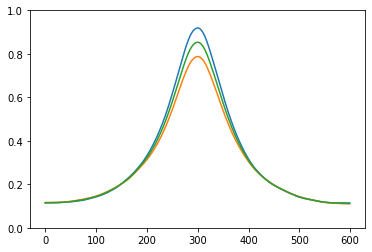

In [157]:
_ = chiplot.plotAverageOfSamples(["../../data/knockouts_v1/AAVS1_mat.gz", "../../data/knockouts_v1/AAVS1_V2_mat.gz"], folder="../../data/"+project+"/"+val, showAll=True, maxv = 1, minv=0)

<Figure size 432x288 with 0 Axes>

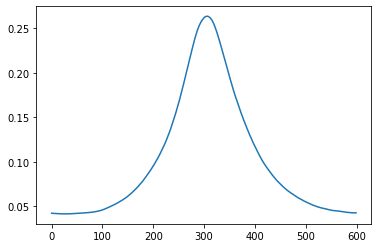

In [152]:
for i, val in enumerate(names):
    if i !=1:
        continue
    val1 = '../../data/'+project+'/' + val +'_mat.gz'
    val2 = '../../data/'+project+'/' + val +'_V2_ko_mat.gz'
    _ = chiplot.plotAverageOfSamples([val1, val2], folder="../../data/"+project+"/"+val, maxv=1, minv=0)

In [153]:
h.createFoldersFor('../results/'+project+'/plots/scaled/heatmaps/')
! cp ../../data/$project/*.pdf ../results/$project/plots/scaled/heatmaps/

#### Looking at TSS

In [ ]:
IRF8targets = h.fileToList('../results/slamseqMax/IRF8targets.txt')

In [ ]:
ls ../../data/chipseq_IRF8_degraded/recalib_bigwig/*

In [ ]:
peaksVHL = pd.read_csv('../../data/chipseq_IRF8_degraded/diffPeaks/MV411_IRF8_NT_DMSO-POLII_total_R1_treat_pileup_vs_MV411_IRF8_NT_VHL-POLII_total_R1_treat_pileup_c3.0_cond2.bed', sep='\t',header=None, skiprows=1, names=['chrom','start','end','name','score'])
peaksVHL['chrom']= [i[3:] for i in peaksVHL['chrom']]
peaksVHL[['start','end']] = peaksVHL[['start','end']].astype(int)

In [ ]:
peaksDMSO = pd.read_csv('../../data/chipseq_IRF8_degraded/diffPeaks/MV411_IRF8_NT_DMSO-POLII_total_R1_treat_pileup_vs_MV411_IRF8_NT_VHL-POLII_total_R1_treat_pileup_c3.0_cond1.bed', sep='\t', header=None, skiprows=1, names=['chrom','start','end','name','score'])
peaksDMSO['chrom']= [i[3:] for i in peaksDMSO['chrom']]
peaksDMSO[['start','end']] = peaksDMSO[['start','end']].astype(int)

In [ ]:
peakcommon = pd.read_csv('../../data/chipseq_IRF8_degraded/diffPeaks/MV411_IRF8_NT_DMSO-POLII_total_R1_treat_pileup_vs_MV411_IRF8_NT_VHL-POLII_total_R1_treat_pileup_c3.0_common.bed', sep='\t',header=None, skiprows=1, names=['chrom','start','end','name','score'])
peakcommon['chrom']= [i[3:] for i in peakcommon['chrom']]
peakcommon[['start','end']] = peakcommon[['start','end']].astype(int)

In [ ]:
ensembltss['Chromosome/scaffold name'] = ensembltss['Chromosome/scaffold name'].astype(str)
ensembltss = ensembltss[ensembltss['Chromosome/scaffold name'].isin(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9','X','Y'])]
ensembltss = ensembltss.drop_duplicates('Gene start (bp)')
ensembltss = ensembltss.reset_index(drop=True)
ensembltss = ensembltss.astype(str)
ensembltss['loci'] = ensembltss['Transcription start site (TSS)'].astype(int)
ensembltss['chrom'] = ensembltss['Chromosome/scaffold name']
ensembltss = ensembltss.sort_values(by=['chrom','loci']).reset_index(drop=True)

In [ ]:
chip.substractPeaksTo(peaksDMSO, ensembltss).to_csv('../../data/'+project+'/diffPeaks/polII_DMSO_TSSonly.bed',sep='\t',index=None,header=False)
chip.substractPeaksTo(peakcommon, ensembltss).to_csv('../../data/'+project+'/diffPeaks/polII_common_TSSonly.bed',sep='\t',index=None,header=False)
chip.substractPeaksTo(peaksVHL, ensembltss).to_csv('../../data/'+project+'/diffPeaks/polII_VHL_TSSonly.bed',sep='\t',index=None,header=False)

In [ ]:
chip.getPeaksAt(['../../data/'+project+'/diffPeaks/polII_DMSO_TSSonly.bed', '../../data/'+project+'/diffPeaks/polII_common_TSSonly.bed', '../../data/'+project+'/diffPeaks/polII_VHL_TSSonly.bed'],
                bigwigs = ['../../data/chipseq_IRF8_degraded/recalib_bigwig/MV411_IRF8_NT_DMSO-POLII_total_R1.bw', '../../data/chipseq_IRF8_degraded/recalib_bigwig/MV411_IRF8_NT_VHL-POLII_total_R1.bw'], 
                bigwignames= ['IRF8_DMSO', 'IRF8_VHL'], 
                peaknames=['DMSO','common','VHL'], window=3000, folder="", title='polII_with_IRF8_degron', numthreads=4, 
                refpoint="center", 
                name='../../data/'+project+'/diffPeaks/polII_with_IRF8_degron_mat.pdf', 
                withDeeptools=True, torecompute=True, legendLoc="lower-left")

In [ ]:
IRF8tss = ensembltss[ensembltss['Gene name'].isin(IRF8targets)].reset_index(drop=True)

In [ ]:
a = ! wc -l ../../data/$project/diffPeaks/polII_DMSO_TSSonly.bed 

In [ ]:
int(a[0].split(' ')[0])/len(peaksDMSO), len(peaksDMSO)

In [ ]:
len(chip.substractPeaksTo(peaksDMSO, IRF8tss))/int(a[0].split(' ')[0])

In [ ]:
a = ! wc -l ../../data/$project/diffPeaks/polII_common_TSSonly.bed 

In [ ]:
int(a[0].split(' ')[0])/ len(peakcommon),  len(peakcommon)

In [ ]:
len(chip.substractPeaksTo(peakcommon, IRF8tss))/int(a[0].split(' ')[0])

In [ ]:
a = ! wc -l ../../data/$project/diffPeaks/polII_VHL_TSSonly.bed 

In [ ]:
len(peaksVHL)

In [ ]:
int(a[0].split(' ')[0])/len(peaksVHL),  len(peaksVHL)

In [ ]:
len(chip.substractPeaksTo(peaksVHL, IRF8tss))/int(a[0].split(' ')[0])

### on unscalled data

In [ ]:
! mkdir ../../data/$project/diffPeaks_unscaled

In [ ]:
#on unscalled data 
for i in range(int(len(bams)/2)):
    if i < 0:
        continue
    name1 = bams[1+i]
    name2 = bams[1+len(names)+i]
    print(name1,name2)
    chip.fullDiffPeak(name1,name2, control1='../../data/'+project+'/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam', directory = "../../data/"+project+"/diffData_unscaled/", res_directory = "../../data/"+project+"/diffPeaks_unscaled/",pairedend=False)

In [ ]:
bw = ! ls ../../data/$project/bwa/mergedLibrary/bigwig/*.bigWig
bw

In [ ]:
cond1peak = ! ls ../../data/$project/diffPeaks_unscaled/*cond1.bed
cond2peak = ! ls ../../data/$project/diffPeaks_unscaled/*cond2.bed
commonpeak = ! ls ../../data/$project/diffPeaks_unscaled/*common.bed
commonpeak

In [ ]:
for i in range(int((len(bw)-1)/2)):
    name1 = bw[1+i]
    name2 = bw[1+len(names)+i]
    peak = [cond1peak[i], commonpeak[i], cond2peak[i]]
    #for val in peak:
     #   chip.dropWeirdChromosomes(val)
    name = names[i]
    print(name1,name2)
    chip.getPeaksAt(peak, [name1, name2], bigwignames=['DMSO', 'VHL'], peaknames=['DMSO_peaks', 'common', 'VHL_peaks'], window=3000, folder="", title=name, numthreads=8, torecompute=True, refpoint='center', name='../../data/'+project+'/diffPeaks_unscaled/'+name+'_mat.pdf', withDeeptools=True)

In [ ]:
h.createFoldersFor('../results/'+project+'/plots/unscaled/diffPeaks/')
! cp ../../data/$project/diffPeaks_unscaled/*.pdf ../results/$project/plots/unscaled/diffPeaks/

! gsutil -m cp gs://amlproject/Chip/$project/bwa/mergedLibrary/deepTools/**.pdf ../results/$project/plots/

In [ ]:
! gsutil -m cp -r ../../data/$project/diffPeaks gs://amlproject/Chip/$project/
! gsutil -m cp -r ../../data/$project/diffData gs://amlproject/Chip/$project/
! gsutil -m cp -r ../../data/$project/diffPeaks_unscaled gs://amlproject/Chip/$project/
! gsutil -m cp -r ../../data/$project/diffData_unscaled gs://amlproject/Chip/$project/
! gsutil -m cp -r ../../data/$project/peakplot gs://amlproject/Chip/$project/

In [ ]:
! gsutil -m cp -r gs://amlproject/Chip/$project/diffPeaks ../../data/$project/
! gsutil -m cp -r gs://amlproject/Chip/$project/diffData ../../data/$project/
! gsutil -m cp -r gs://amlproject/Chip/$project/diffPeaks_unscaled ../../data/$project/
! gsutil -m cp -r gs://amlproject/Chip/$project/diffData_unscaled ../../data/$project/
! gsutil -m cp -r gs://amlproject/Chip/$project/peakplot ../../data/$project/

Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/AAVS1_mat.gz...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/AAVS1_v2_mat.gz...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/AAVS1_mat.pdf...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/AAVS1_v2_mat.pdf...         
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/IRF8_mat.pdf...             
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/IRF8_mat.gz...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/IRF8_v2_mat.gz...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/IRF8_v2_mat.pdf...          
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/MEF2D_v2_mat.gz...          
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/MEF2D_mat.pdf...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/MEF2D_v2_mat.pdf...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/MV411_RNP_AAVS1-H3K27AC_R1_treat_pileup_vs_MV411_RNP_IRF8-H3K27AC_R1_treat_pileup_c3.0_common.bed...
Copying gs://amlproject/Chip/knockout

- [73/73 files][  1.8 GiB/  1.8 GiB] 100% Done                                  
Operation completed over 73 objects/1.8 GiB.                                     
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_control_lambda.bdg...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_peaks.narrowPeak...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_peaks.xls...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_summits.bed...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_treat_pileup.bdg...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R2_control_lambda.bdg...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R2_peaks.narrowPeak...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R2_peaks.xls...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H